In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('RSCCASN.csv', parse_dates=True, index_col='observation_date') # read the data and set the index to the date column
df.columns = ['Sales'] # rename the column to 'Sales'

In [3]:
df.head()

,Sales
observation_date,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<Axes: xlabel='observation_date'>

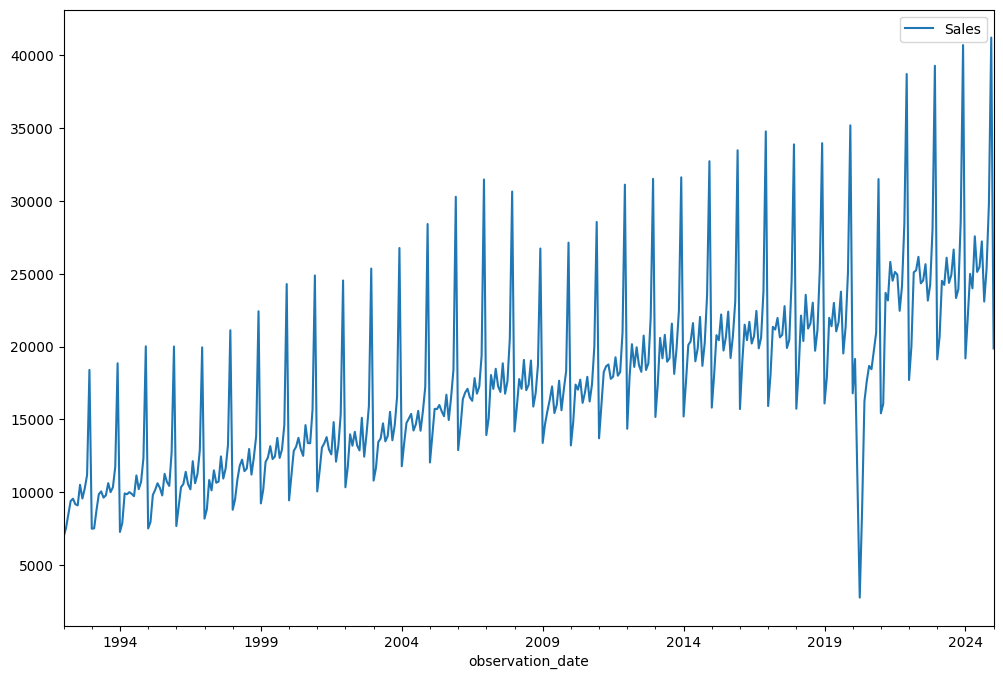

In [4]:
df.plot(figsize=(12,8))

In [5]:
test_size = 24 # 24 months
test_ind = len(df) - test_size

In [6]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()

In [9]:
scaler.fit(train)
scaled_train = scaler.transform(train)

In [10]:
scaled_test = scaler.transform(test)

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [12]:
length = 12 # Length of the output sequences (in number of timesteps), should be less than the length of the time series
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [13]:
X,y = generator[0]

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU

In [15]:
n_features = 1

In [16]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

d:\Users\Higor\Documents\Anomalias_de_Codigo\tensor-keras-curso\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=2) # stop training when a monitored quantity has stopped improving

In [20]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1) # create a separate validation generator

In [21]:
model.fit(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20


d:\Users\Higor\Documents\Anomalias_de_Codigo\tensor-keras-curso\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0306 - val_loss: 0.0203
Epoch 2/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0132 - val_loss: 0.0215
Epoch 3/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099 - val_loss: 0.0117
Epoch 4/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075 - val_loss: 0.0080
Epoch 5/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 6/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060 - val_loss: 0.0165
Epoch 7/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 8/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029 - val_loss: 6.4815e-04
Epoch 9/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 10/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078 - val_loss: 0.0023


<Axes: >

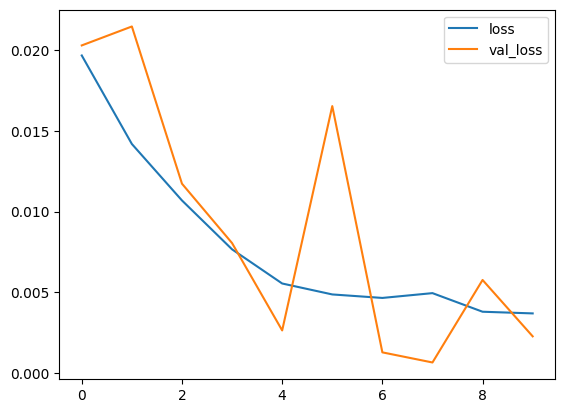

In [22]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [23]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
        
        # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
        current_pred = model.predict(current_batch)[0]
        
        # store prediction
        test_predictions.append(current_pred) 
        
        # update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [24]:
true_predictions = scaler.inverse_transform(test_predictions)

In [25]:
test['Predictions'] = true_predictions

C:\Users\higor\AppData\Local\Temp\ipykernel_1600\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


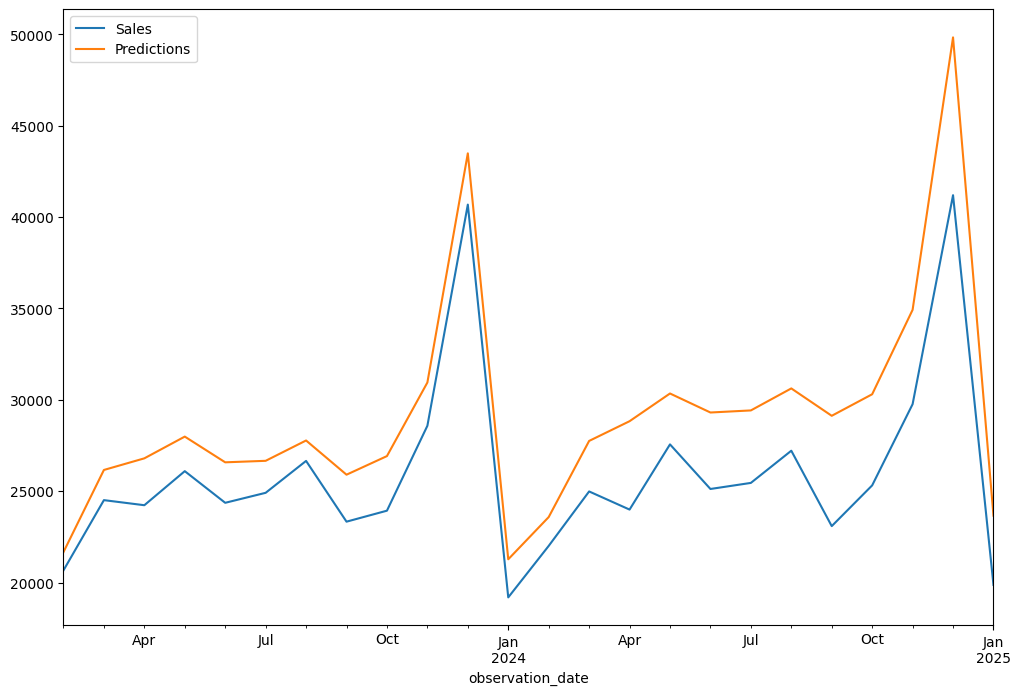

In [26]:
test.plot(figsize=(12,8))
plt.show()

In [27]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [28]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [29]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

d:\Users\Higor\Documents\Anomalias_de_Codigo\tensor-keras-curso\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
model.fit(generator,epochs=8)

Epoch 1/8


d:\Users\Higor\Documents\Anomalias_de_Codigo\tensor-keras-curso\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0402
Epoch 2/8
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0146
Epoch 3/8
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091
Epoch 4/8
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114
Epoch 5/8
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0049
Epoch 6/8
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055
Epoch 7/8
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0053
Epoch 8/8
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026


In [31]:
forecast = []

periods = 36

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(periods):
        
        # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
        current_pred = model.predict(current_batch)[0]
        
        # store prediction
        test_predictions.append(current_pred) 
        
        # update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [32]:
forecast = scaler.inverse_transform(test_predictions)

In [33]:
df

,Sales
observation_date,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2024-09-01,23088
2024-10-01,25318
2024-11-01,29762


In [34]:
forecast_index = pd.date_range(start='2025-02-01',periods=periods,freq='MS')

In [35]:
forecast_index

DatetimeIndex(['2025-02-01', '2025-03-01', '2025-04-01', '2025-05-01',
               '2025-06-01', '2025-07-01', '2025-08-01', '2025-09-01',
               '2025-10-01', '2025-11-01', '2025-12-01', '2026-01-01',
               '2026-02-01', '2026-03-01', '2026-04-01', '2026-05-01',
               '2026-06-01', '2026-07-01', '2026-08-01', '2026-09-01',
               '2026-10-01', '2026-11-01', '2026-12-01', '2027-01-01',
               '2027-02-01', '2027-03-01', '2027-04-01', '2027-05-01',
               '2027-06-01', '2027-07-01', '2027-08-01', '2027-09-01',
               '2027-10-01', '2027-11-01', '2027-12-01', '2028-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [36]:
forecast

array([[21666.02078587],
       [26161.63889688],
       [26797.44446939],
       [27987.44644427],
       [26579.82798994],
       [26662.11569601],
       [27774.4927246 ],
       [25902.84485507],
       [26920.76402658],
       [30948.70124215],
       [43488.78698623],
       [21273.09193295],
       [23582.78042132],
       [27750.48734099],
       [28829.87055957],
       [30346.8442145 ],
       [29306.08969891],
       [29419.97934639],
       [30624.43718147],
       [29125.8557651 ],
       [30304.93157154],
       [34925.57427877],
       [49836.35585141],
       [23660.07479882],
       [26241.28640223],
       [28628.50197113],
       [28119.88274074],
       [31027.93118691],
       [29337.08922219],
       [29766.64161742],
       [31320.38887548],
       [28478.6151222 ],
       [30354.00581336],
       [34448.97455037],
       [47014.07695758],
       [27507.66064167],
       [32968.75710022],
       [35393.90978742],
       [35188.34819484],
       [38196.56333411],


In [41]:
forecast_df = pd.DataFrame(data=forecast[:len(forecast_index)], index=forecast_index, columns=['Forecast'])

<Axes: >

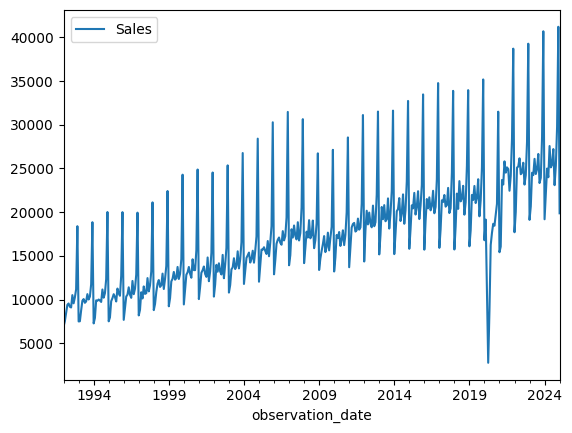

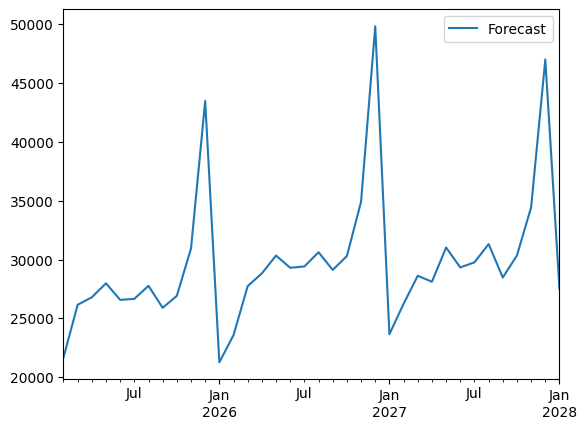

In [42]:
df.plot()
forecast_df.plot()

(576.0, 672.0)

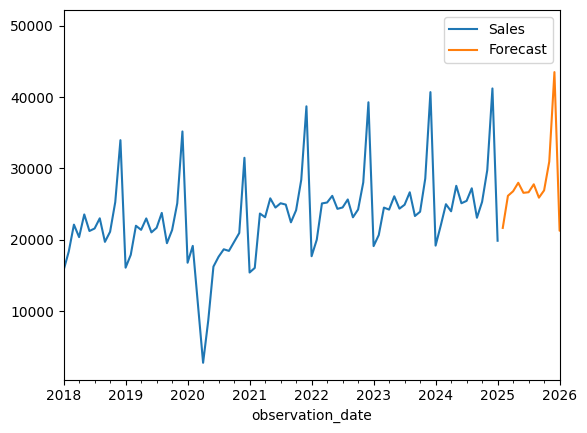

In [43]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2026-01-01')